In [ ]:
# 기상습도로 예측하자니 결과과 별로 좋지 않다,
# 따라서 기상온도 / 기상습도로 => 공장내 습도를 예측하고
# 기상온도 + 공장내 습도(예측)로 결로 현상을 예측하는 모델을 만들어 보자


# 그전에 '기상온도','기상습도','tem_in_loc1','tem_coil_loc1','tem_out_loc1','hum_out_loc1'
# 위 6개 특성으로 hum_in_loc1을 예측해보자


In [41]:
import pandas as pd
from numpy import mean
from scipy import stats #scipy란 과학기술 통계분석함수 모음이다.
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False
import mglearn 
import missingno as msno
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,LSTM,Dropout
from keras.optimizers import Adam
from IPython .display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import np_utils
from numpy import argmax

In [42]:
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_tem_hum.csv')


In [43]:
datanew=datanew[['기상온도','기상습도','tem_in_loc1','hum_in_loc1','tem_coil_loc1','tem_out_loc1','hum_out_loc1']]


In [44]:
datanew=datanew.dropna(axis=0)

In [45]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

#https://blog.naver.com/PostView.nhn?blogId=gudrb1707&logNo=221275862122 참조함

In [51]:
datanew

,기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
0,6.8,41.2,16.0,24.00,11.00,9.00,42.00
1,5.2,52.1,14.0,28.00,10.00,7.00,59.00
2,6.8,40.9,13.0,33.00,10.00,6.00,56.00
3,13.9,28.9,13.0,33.00,10.00,18.00,30.00
4,20.4,17.7,16.0,28.00,10.00,18.00,20.00
...,...,...,...,...,...,...,...
57642,3.7,48.4,10.5,35.29,10.40,6.64,42.67
57643,3.6,48.8,10.4,35.68,10.48,6.49,42.46
57644,3.6,48.2,10.4,36.11,10.52,6.52,42.40
57645,3.5,48.0,10.4,35.96,10.48,6.52,42.12


In [52]:
#신경망에서 학습을 빠르게 하기위해 정규화 해준다
datanew=MinMaxScaler(datanew)

In [53]:
datanew

,기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
0,0.432532,0.394432,0.532151,0.175439,0.438192,0.434175,0.394919
1,0.402957,0.520882,0.487805,0.225564,0.414646,0.395905,0.576369
2,0.432532,0.390951,0.465632,0.288221,0.414646,0.376770,0.544348
3,0.563771,0.251740,0.465632,0.288221,0.414646,0.606391,0.266837
4,0.683919,0.121810,0.532151,0.225564,0.414646,0.606391,0.160102
...,...,...,...,...,...,...,...
57642,0.375231,0.477958,0.410200,0.316917,0.424064,0.389016,0.402071
57643,0.373383,0.482599,0.407982,0.321805,0.425948,0.386146,0.399829
57644,0.373383,0.475638,0.407982,0.327193,0.426890,0.386720,0.399189
57645,0.371534,0.473318,0.407982,0.325313,0.425948,0.386720,0.396200


In [8]:
datanew.iloc[1,:].values

array([0.40295749, 0.52088167, 0.48780488, 0.22556391, 0.41464563,
       0.39590509, 0.57636888])

In [9]:
result=[]
for i in range(datanew.shape[0]):
    result.append(datanew.iloc[i,:].values)
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
result=np.array(result)


In [11]:
#데이터 나누기
row = int(round(result.shape[0]*0.9))
result.shape
#7가지 특성 : 기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
row #테스트용

51882

In [12]:
np.random.seed(0)
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

In [13]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((51882, 6, 1), (5765, 6, 1), (51882,), (5765,))

In [17]:
# step 3. 모델생성
model = Sequential()
model.add(LSTM(12, input_shape=(6,1), return_sequences=True,activation='relu'))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='tanh'))
model.compile('adam', 'mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 12)             672       
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                19712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 20,449
Trainable params: 20,449
Non-trainable params: 0
_________________________________________________________________


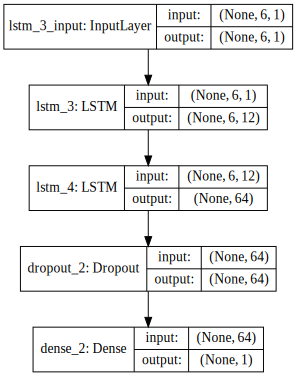

In [18]:
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [19]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1024, epochs=100)

Train on 51882 samples, validate on 5765 samples
Epoch 1/100
51882/51882 [==============================] - 3s 49us/step - loss: 0.1130 - accuracy: 1.9275e-05 - val_loss: 0.0316 - val_accuracy: 0.0000e+00
Epoch 2/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0301 - accuracy: 1.9275e-05 - val_loss: 0.0281 - val_accuracy: 0.0000e+00
Epoch 3/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0283 - accuracy: 1.9275e-05 - val_loss: 0.0270 - val_accuracy: 0.0000e+00
Epoch 4/100
51882/51882 [==============================] - 2s 38us/step - loss: 0.0268 - accuracy: 1.9275e-05 - val_loss: 0.0257 - val_accuracy: 0.0000e+00
Epoch 5/100
51882/51882 [==============================] - 2s 38us/step - loss: 0.0256 - accuracy: 1.9275e-05 - val_loss: 0.0256 - val_accuracy: 0.0000e+00
Epoch 6/100
51882/51882 [==============================] - 2s 39us/step - loss: 0.0252 - accuracy: 1.9275e-05 - val_loss: 0.0249 - val_accuracy: 0.0000e+00
Epoch 7/100
518

Epoch 53/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0064 - accuracy: 3.8549e-05 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 54/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0064 - accuracy: 3.8549e-05 - val_loss: 0.0055 - val_accuracy: 0.0000e+00
Epoch 55/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0063 - accuracy: 1.9275e-05 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 56/100
51882/51882 [==============================] - 2s 37us/step - loss: 0.0064 - accuracy: 3.8549e-05 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 57/100
51882/51882 [==============================] - 2s 38us/step - loss: 0.0061 - accuracy: 1.9275e-05 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 58/100
51882/51882 [==============================] - 2s 38us/step - loss: 0.0060 - accuracy: 3.8549e-05 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 59/100
51882/51882 [==============================] 

In [20]:
pred = model.predict(x_test)
data_standadized_np = (pred - mean(pred,)) / (pred)

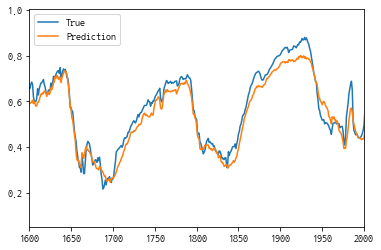

In [21]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(1600,2000)
plt.show()

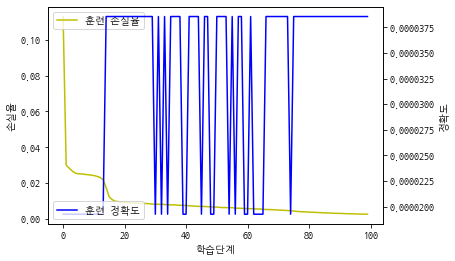

In [22]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')


plt.show()

In [23]:
#훈련을 할수록 손실율이 감소한다
#이번엔 기상온도와 습도 데이터만으로 공장내 습도를 예측해보자


In [16]:
datanew=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_tem_hum.csv')

In [17]:
datanew=datanew[['기상온도','기상습도','hum_in_loc1']]
datanew=datanew.dropna(axis=0)

In [18]:
#신경망에서 학습을 빠르게 하기위해 정규화 해준다
datanew=MinMaxScaler(datanew)

In [19]:
result=[]

for i in range(datanew.shape[0]):
    result.append(datanew.iloc[i,:].values)
result=np.array(result)


In [20]:
#데이터 나누기
row = int(round(result.shape[0]*0.9))
result.shape
#7가지 특성 : 기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
row #테스트용

51882

In [21]:
datanew

,기상온도,기상습도,hum_in_loc1
0,0.432532,0.394432,0.175439
1,0.402957,0.520882,0.225564
2,0.432532,0.390951,0.288221
3,0.563771,0.251740,0.288221
4,0.683919,0.121810,0.225564
...,...,...,...
57642,0.375231,0.477958,0.316917
57643,0.373383,0.482599,0.321805
57644,0.373383,0.475638,0.327193
57645,0.371534,0.473318,0.325313


In [22]:
np.random.seed(0)
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]


In [23]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((51882, 2, 1), (5765, 2, 1), (51882,), (5765,))

In [24]:
# step 3. 모델생성
model = Sequential()
model.add(LSTM(12, input_shape=(2,1), return_sequences=True,activation='relu'))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='tanh'))
model.compile('adam', 'mse',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2, 12)             672       
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                19712     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 20,449
Trainable params: 20,449
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=1024, epochs=100)

Train on 51882 samples, validate on 5765 samples
Epoch 1/100
51882/51882 [==============================] - 3s 57us/step - loss: 0.1373 - accuracy: 7.7098e-05 - val_loss: 0.0158 - val_accuracy: 0.0000e+00
Epoch 2/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0223 - accuracy: 3.8549e-05 - val_loss: 0.0159 - val_accuracy: 0.0000e+00
Epoch 3/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0200 - accuracy: 3.8549e-05 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 4/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0158 - accuracy: 5.7824e-05 - val_loss: 0.0104 - val_accuracy: 0.0000e+00
Epoch 5/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0130 - accuracy: 9.6373e-05 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 6/100
51882/51882 [==============================] - 1s 14us/step - loss: 0.0111 - accuracy: 9.6373e-05 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 7/100
518

Epoch 53/100
51882/51882 [==============================] - 1s 12us/step - loss: 0.0080 - accuracy: 9.6373e-05 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 54/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0079 - accuracy: 9.6373e-05 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 55/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0080 - accuracy: 9.6373e-05 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 56/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0080 - accuracy: 9.6373e-05 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 57/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0080 - accuracy: 9.6373e-05 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 58/100
51882/51882 [==============================] - 1s 13us/step - loss: 0.0080 - accuracy: 9.6373e-05 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 59/100
51882/51882 [==============================] 

In [27]:
pred = model.predict(x_test)
data_standadized_np = (pred - mean(pred,)) / (pred)

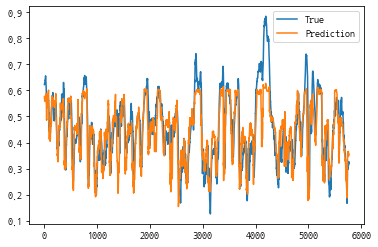

In [28]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()

plt.show()

In [29]:
#예측모델의 특성이 2개밖에 안되서 그런지 예측율이 바닥을 긴다.
# 서산 ASOS의 데이터를 가져온다
# 총 47개이며
# plant1_traincp의 일시와 동일한 값들만 끌고온다
plant1_train=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_traincp.csv')
del plant1_train['Unnamed: 0']
plant1_train.columns=plant1_train.columns.str.replace('plant1_train.','')

In [30]:
#datetime으로 변경한다.

plant1_train['mea_ddhr'] = pd.to_datetime(plant1_train['mea_ddhr'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [31]:
for i in range(1,48):
    globals()['weather{}'.format(i)]=pd.read_csv('C:/Anaconda3/python/csvdata/hyundae/서산 ASOS 지상 기상 데이터/분별/1_ ({}).csv'.format(i))
    del globals()['weather{}'.format(i)]['지점']

In [32]:
lis=[]
for i in range(1,48):
    lis.append(globals()['weather{}'.format(i)])

In [33]:
weather=pd.concat(lis, axis=0)

In [34]:
weather=weather.reset_index(drop=True)

In [35]:
weather

,시간,기온(°C),누적강수량(mm),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec),일시
0,2016-01-01 00:01,-3.2,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,NaN
1,2016-01-01 00:02,-3.0,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,NaN
2,2016-01-01 00:03,-3.0,0.0,325.2,0.1,1030.3,1034.1,97.4,0.00,0.0,NaN
3,2016-01-01 00:04,-3.1,0.0,336.3,0.1,1030.3,1034.1,97.4,0.00,0.0,NaN
4,2016-01-01 00:05,-3.3,0.0,340.2,0.1,1030.3,1034.1,97.4,0.00,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2055715,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.1,11.05,29820.0,2019-12-31 23:56
2055716,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.3,11.05,29820.0,2019-12-31 23:57
2055717,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.4,11.05,29820.0,2019-12-31 23:58
2055718,NaN,-7.2,0.1,59.9,0.1,1030.9,1034.2,83.6,11.05,29820.0,2019-12-31 23:59


In [36]:
weather['시간'][2055715]

nan

In [39]:
weather
# pd.isnull(weather['시간'][i])

,시간,기온(°C),누적강수량(mm),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec),일시
0,2016-01-01 00:01,-3.2,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:01
1,2016-01-01 00:02,-3.0,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:02
2,2016-01-01 00:03,-3.0,0.0,325.2,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:03
3,2016-01-01 00:04,-3.1,0.0,336.3,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:04
4,2016-01-01 00:05,-3.3,0.0,340.2,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:05
...,...,...,...,...,...,...,...,...,...,...,...
2055715,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.1,11.05,29820.0,2019-12-31 23:56
2055716,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.3,11.05,29820.0,2019-12-31 23:57
2055717,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.4,11.05,29820.0,2019-12-31 23:58
2055718,NaN,-7.2,0.1,59.9,0.1,1030.9,1034.2,83.6,11.05,29820.0,2019-12-31 23:59


In [40]:
weather
#해당파일을 보면 어떤 순간부터 시간이 일시로 변경되었다. 시간데이터를 일시로 보내준다.
for i in range(datanew.shape[0]):
    if pd.isnull(weather['일시'][i])==True:
        weather['일시'][i]=weather['시간'][i]         
    elif pd.isnull(weather['일시'][i])==False:
        pass        
    else:
        pass

In [54]:
weather

,시간,기온(°C),누적강수량(mm),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec),일시
0,2016-01-01 00:01,-3.2,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:01
1,2016-01-01 00:02,-3.0,0.0,0.0,0.0,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:02
2,2016-01-01 00:03,-3.0,0.0,325.2,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:03
3,2016-01-01 00:04,-3.1,0.0,336.3,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:04
4,2016-01-01 00:05,-3.3,0.0,340.2,0.1,1030.3,1034.1,97.4,0.00,0.0,2016-01-01 00:05
...,...,...,...,...,...,...,...,...,...,...,...
2055715,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.1,11.05,29820.0,2019-12-31 23:56
2055716,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.3,11.05,29820.0,2019-12-31 23:57
2055717,NaN,-7.2,0.1,0.0,0.1,1031.0,1034.3,83.4,11.05,29820.0,2019-12-31 23:58
2055718,NaN,-7.2,0.1,59.9,0.1,1030.9,1034.2,83.6,11.05,29820.0,2019-12-31 23:59


In [55]:
del weather['시간']

In [ ]:
weather['일시']

In [64]:
weather['일시'] = pd.to_datetime(weather['일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [65]:
plant1_train.rename(columns = {'mea_ddhr' : '일시'}, inplace = True)

In [66]:
plant1_train['일시']

0       2016-04-01 00:00:00
1       2016-04-01 03:00:00
2       2016-04-01 06:00:00
3       2016-04-01 09:00:00
4       2016-04-01 12:00:00
                ...        
58744   2019-03-31 23:10:00
58745   2019-03-31 23:20:00
58746   2019-03-31 23:30:00
58747   2019-03-31 23:40:00
58748   2019-03-31 23:50:00
Name: 일시, Length: 58749, dtype: datetime64[ns]

In [67]:
plant1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58749 entries, 0 to 58748
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   일시             58749 non-null  datetime64[ns]
 1   tem_in_loc1    57879 non-null  float64       
 2   hum_in_loc1    57879 non-null  float64       
 3   tem_coil_loc1  57879 non-null  float64       
 4   tem_in_loc2    58629 non-null  float64       
 5   hum_in_loc2    58629 non-null  float64       
 6   tem_coil_loc2  58629 non-null  float64       
 7   tem_in_loc3    58604 non-null  float64       
 8   hum_in_loc3    58604 non-null  float64       
 9   tem_coil_loc3  58629 non-null  float64       
 10  tem_out_loc1   58629 non-null  float64       
 11  hum_out_loc1   58629 non-null  float64       
 12  cond_loc1      57879 non-null  float64       
 13  cond_loc2      58629 non-null  float64       
 14  cond_loc3      58604 non-null  float64       
dtypes: datetime64[ns](1

In [68]:
# weather의 자료를 plant1_train에 추가 해줄것이다.
# weahter은 분당 자료이므로 plant1_train의 'mea_ddhr'의 시간과 동일한 데이터만 추가해줄것
df_plant1=pd.merge(plant1_train,weather , on='일시')

In [69]:
df_plant1=df_plant1.dropna(axis=0)

In [70]:
df_plant1=df_plant1.reset_index(drop=True)

In [71]:
df_plant1.columns

Index(['일시', 'tem_in_loc1', 'hum_in_loc1', 'tem_coil_loc1', 'tem_in_loc2',
       'hum_in_loc2', 'tem_coil_loc2', 'tem_in_loc3', 'hum_in_loc3',
       'tem_coil_loc3', 'tem_out_loc1', 'hum_out_loc1', 'cond_loc1',
       'cond_loc2', 'cond_loc3', '기온(°C)', '누적강수량(mm)', '풍향(deg)', '풍속(m/s)',
       '현지기압(hPa)', '해면기압(hPa)', '습도(%)', '일사(MJ/m^2)', '일조(Sec)'],
      dtype='object')

In [72]:
#데이터 전처리가 완료되었다, 훈련데이터를 만들자
#사용할 특성 데이터
# 기온(°C)	누적강수량(mm)	풍향(deg)	풍속(m/s)	현지기압(hPa)	해면기압(hPa)	습도(%)	일사(MJ/m^2)	일조(Sec)
# 예측할 특성 tem_in_loc1랑 hum_in_loc1인데 일단 hum_in_loc1부터 하자
dataaa=df_plant1[['기온(°C)','누적강수량(mm)','풍향(deg)','풍속(m/s)','현지기압(hPa)','해면기압(hPa)','습도(%)','일사(MJ/m^2)','일조(Sec)','hum_in_loc1']]
dataaa=MinMaxScaler(dataaa)


In [103]:
result=[]

for i in range(dataaa.shape[0]):
    result.append(dataaa.iloc[i,:].values)
result=np.array(result)

In [104]:
result.shape

(54803, 10)

In [105]:
#데이터 나누기
row = int(round(result.shape[0]*0.9))
result.shape
#7가지 특성 : 기상온도,기상습도,tem_in_loc1,hum_in_loc1,tem_coil_loc1,tem_out_loc1,hum_out_loc1
row #테스트용

49323

In [106]:
np.random.seed(0)
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]


In [107]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((49323, 9, 1), (5480, 9, 1), (49323,), (5480,))

In [108]:
x_train

array([[[0.4452975 ],
        [0.005743  ],
        [0.04722222],
        ...,
        [0.83626374],
        [0.06968952],
        [0.04357542]],

       [[0.27639155],
        [0.00143575],
        [0.2225    ],
        ...,
        [0.7989011 ],
        [0.09090909],
        [0.27597765]],

       [[0.62380038],
        [0.        ],
        [0.84055556],
        ...,
        [0.96703297],
        [0.        ],
        [0.        ]],

       ...,

       [[0.24568138],
        [0.        ],
        [0.08972222],
        ...,
        [0.84065934],
        [0.10096046],
        [0.05027933]],

       [[0.38579654],
        [0.        ],
        [0.99083333],
        ...,
        [0.49120879],
        [0.07527362],
        [0.13854749]],

       [[0.57389635],
        [0.        ],
        [0.48333333],
        ...,
        [0.94175824],
        [0.33951307],
        [0.43910615]]])

In [109]:
# step 3. 모델생성
model = Sequential()
model.add(LSTM(64, input_shape=(9,1), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile('adam', 'mse',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 9, 64)             16896     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [110]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50)

Train on 49323 samples, validate on 5480 samples
Epoch 1/50
49323/49323 [==============================] - 5s 100us/step - loss: 0.0359 - accuracy: 2.0275e-05 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 2/50
49323/49323 [==============================] - 4s 88us/step - loss: 0.0238 - accuracy: 2.0275e-05 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 3/50
49323/49323 [==============================] - 4s 87us/step - loss: 0.0201 - accuracy: 2.0275e-05 - val_loss: 0.0153 - val_accuracy: 0.0000e+00
Epoch 4/50
49323/49323 [==============================] - 4s 87us/step - loss: 0.0114 - accuracy: 4.0549e-05 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 5/50
49323/49323 [==============================] - 4s 87us/step - loss: 0.0086 - accuracy: 4.0549e-05 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 6/50
49323/49323 [==============================] - 4s 87us/step - loss: 0.0083 - accuracy: 4.0549e-05 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 7/50
49323/493

In [111]:
pred = model.predict(x_test)
data_standadized_np = (pred - mean(pred,)) / (pred)

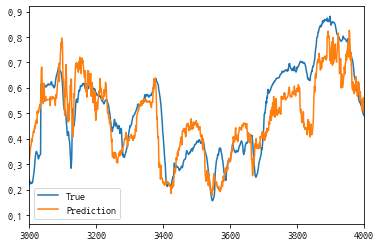

In [112]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(3000,4000)
plt.show()
#비슷하지만 대체로 값의 차이가 조금 심하다
#특성중 크게 영향을 주지 않는 데이터를 삭제해보면 어떨까?


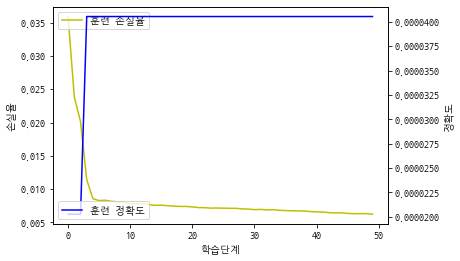

In [113]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')


plt.show()

In [114]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)

testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)


Train Score:  [0.006053838818617181, 4.0549035475123674e-05]
Test Score:  [0.006637095740357292, 0.0]


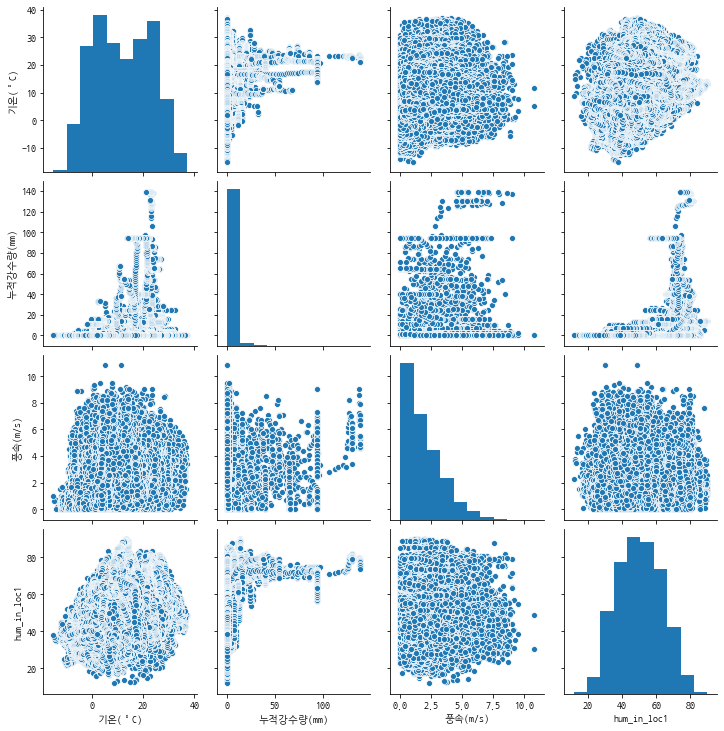

In [94]:
#기상습도에 영향을 크게주는 것을 찾아보자

sns.pairplot(df_plant1[['기온(°C)','누적강수량(mm)','풍속(m/s)','hum_in_loc1']])
plt.show()

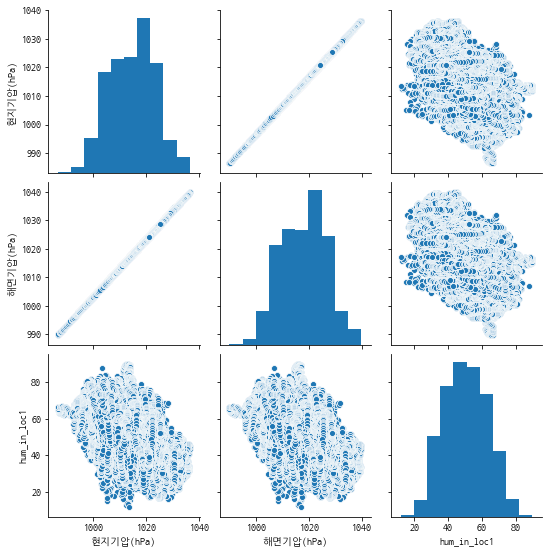

In [102]:
# sns.pairplot(df_plant1[['습도(%)','일사(MJ/m^2)','일조(Sec)','누적강수량(mm)','hum_in_loc1']])
# plt.show()

#결과분석
#습도에 영향을 주는 요소들 : '습도(%)','일사(MJ/m^2)','일조(Sec)','누적강수량(mm)'이다.

# sns.pairplot(df_plant1[['현지기압(hPa)','해면기압(hPa)','hum_in_loc1']])
# plt.show()



In [297]:
df_plant1.to_csv('C:/Anaconda3/python/csvdata/hyundae/plant1_train_with_weather.csv')

In [334]:
dataaa=df_plant1[['기온(°C)','누적강수량(mm)','습도(%)','일사(MJ/m^2)','일조(Sec)','hum_in_loc1']]

In [ ]:
dataaa=MinMaxScaler(dataaa)

In [411]:
dataaa['hum_in_loc1'].max()

89.8

In [296]:
(dataaa.iloc[:,0].values)

array([0.621881  , 0.71401151, 0.71785029, ..., 0.34740883, 0.33205374,
       0.3243762 ])

In [272]:
result=[]

for i in range(dataaa.shape[0]):
    result.append(dataaa.iloc[i,:].values)
print(result)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [273]:
result=np.array(result)

In [274]:
row = int(round(result.shape[0]*0.9))
result.shape
row

49323

In [275]:
np.random.seed(0)
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1]

In [489]:
model = Sequential()
model.add(LSTM(32, input_shape=(5,1), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile('adam', 'mean_squared_error',metrics=['accuracy'])
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 5, 32)             4352      
_________________________________________________________________
lstm_75 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 29,249
Trainable params: 29,249
Non-trainable params: 0
_________________________________________________________________


In [490]:
hist=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50)


Train on 49323 samples, validate on 5480 samples
Epoch 1/50
49323/49323 [==============================] - 3s 57us/step - loss: 0.0445 - accuracy: 2.0275e-05 - val_loss: 0.0156 - val_accuracy: 0.0000e+00
Epoch 2/50
49323/49323 [==============================] - 2s 45us/step - loss: 0.0183 - accuracy: 4.0549e-05 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 3/50
49323/49323 [==============================] - 2s 45us/step - loss: 0.0163 - accuracy: 4.0549e-05 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 4/50
49323/49323 [==============================] - 2s 46us/step - loss: 0.0120 - accuracy: 4.0549e-05 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 5/50
49323/49323 [==============================] - 2s 45us/step - loss: 0.0088 - accuracy: 4.0549e-05 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 6/50
49323/49323 [==============================] - 2s 45us/step - loss: 0.0086 - accuracy: 4.0549e-05 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 7/50
49323/4932

In [ ]:
# 모델 저장 
model.save('C:/Anaconda3/python/deeplearning/model326402relu.h5')



In [496]:
pred = model.predict(x_test)

In [497]:
data_standadized_np = (pred - mean(pred,)) / (pred)

In [498]:
y_test

array([0.48677792, 0.47650834, 0.47573813, ..., 0.32451861, 0.33504493,
       0.34454429])

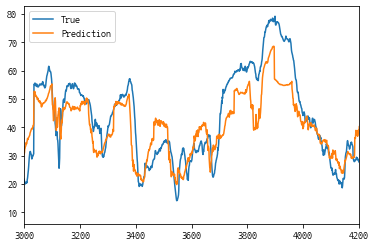

In [500]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test*dataaa['hum_in_loc1'].max(), label='True')
ax.plot(pred*dataaa['hum_in_loc1'].max(), label='Prediction')
ax.legend()
plt.xlim(3000,4200)
plt.show()

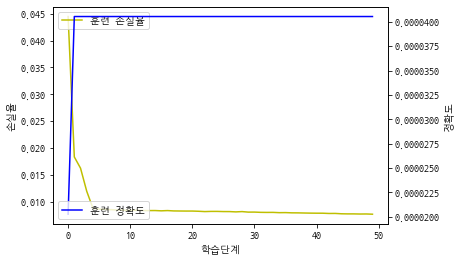

In [495]:
# step7. 모델학습 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='훈련 손실율')
acc_ax.plot(hist.history['accuracy'],'b',label='훈련 정확도')

loss_ax.set_xlabel("학습단계")
loss_ax.set_ylabel("손실율")
acc_ax.set_ylabel("정확도")

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')


plt.show()

In [479]:
# dataaa에서 이상치를 제거해주자

In [430]:
from collections import Counter 


def detect_outliers(df, n, features): 
    outlier_indices = [] 
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        #즉, IQR은 전체 데이터(컬럼의 데이터들)을 4등분했을때 25%~75% 사이값들을 말한다.
        
        outlier_step = 1.2 * IQR
        print(IQR)
        # 결측치는 25%~75%범위의 1.5배 이후 값들을 결측치로 선정한다.
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        print(df[col])
        print(Q1 - outlier_step)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers 

In [431]:
Outliers_to_drop = detect_outliers(dataaa, 2, ["일조(Sec)"])

23760.0
0            0.0
1            0.0
2            0.0
3            0.0
4         5820.0
          ...   
54798    36600.0
54799    36600.0
54800    36600.0
54801    36600.0
54802    36600.0
Name: 일조(Sec), Length: 54803, dtype: float64
-28512.0


In [432]:
Outliers_to_drop

[]